IndexError: list index out of range

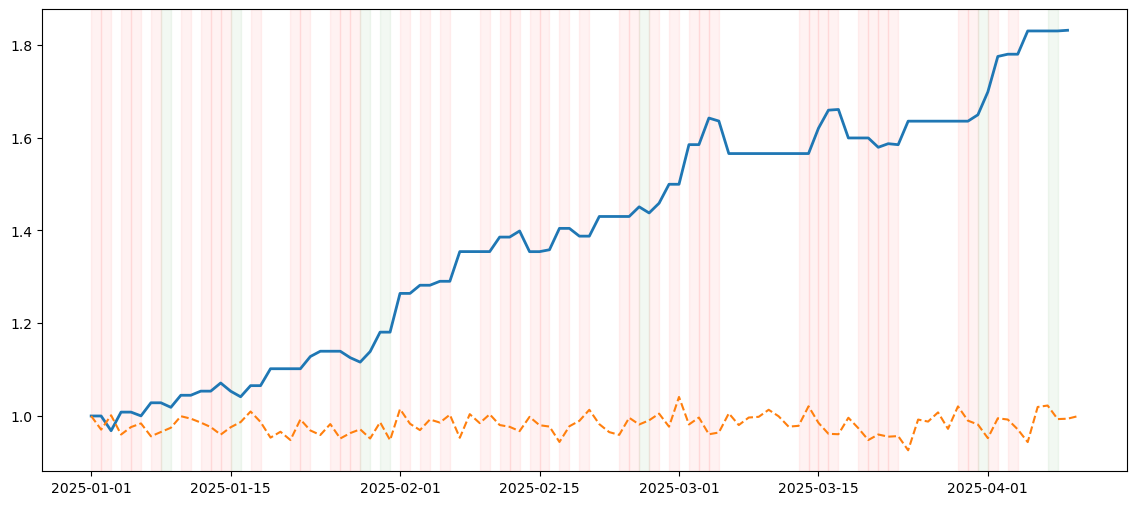

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(123)

# Simulate 100 days
days = 100
dates = pd.date_range(start="2025-01-01", periods=days)

# Simulated fundamental indicators
expected_planting = np.random.normal(95, 4, days)
actual_planting = expected_planting + np.random.normal(0, 4, days)
pod_health_index = np.clip(np.random.normal(0.5, 0.15, days), 0, 1)  # 0 = bad, 1 = great
biofuel_demand = np.cumsum(np.random.normal(0.1, 0.3, days)) + 80
crush_spread = np.random.normal(60, 10, days) + (biofuel_demand - 80) * 0.5  # proxy

# Price simulation (soybean futures)
base_price = 1400
price = base_price + (
    (expected_planting - actual_planting) * 1.8 +
    (pod_health_index - 0.5) * 150 +
    (biofuel_demand - np.mean(biofuel_demand)) * 2 +
    (crush_spread - np.mean(crush_spread)) * 1.5
)

# Strategy signals
signal = []
for i in range(1, days):
    if (actual_planting[i] < expected_planting[i] and
        pod_health_index[i] > 0.5 and
        biofuel_demand[i] > biofuel_demand[i-1] and
        crush_spread[i] > crush_spread[i-1]):
        signal.append(1)  # Long
    elif (actual_planting[i] > expected_planting[i] and
          (pod_health_index[i] < 0.5 or
           biofuel_demand[i] < biofuel_demand[i-1] or
           crush_spread[i] < crush_spread[i-1])):
        signal.append(-1)  # Short
    else:
        signal.append(0)  # Hold

# Compute returns
position = pd.Series(signal).shift(1).fillna(0)
returns = pd.Series(price).pct_change().fillna(0)
strategy_returns = position * returns
portfolio = (1 + strategy_returns).cumprod()
buy_and_hold = (1 + returns).cumprod()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(dates, portfolio, label='Strategy Portfolio', linewidth=2)
plt.plot(dates, buy_and_hold, label='Buy & Hold', linestyle='--', linewidth=1.5)

# Highlight trading zones
for i in range(1, days):
    if signal[i] == 1:
        plt.axvspan(dates[i-1], dates[i], color='green', alpha=0.05)
    elif signal[i] == -1:
        plt.axvspan(dates[i-1], dates[i], color='red', alpha=0.05)

plt.title("Soybean Futures Trading Strategy vs Buy & Hold", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Portfolio Value (normalized)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()